In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

from chiseling.dgps.bart_dataset import BARTDataset
from chiseling.source.strategies.chiseling import Chiseling
from chiseling.source.learners.baselearners_causal import make_interpretable_facet_causal_random_forest_classifier_learner
from chiseling.source.protocol.IRST import UnitRegistrar
from chiseling.source.protocol.utils import aipw_intercept_pseudo_outcome

### Config

In [2]:
BART_PATH = "./bart_dataset_processed.tsv.gz"
RANDOM_SEED = 42

alpha = 0.05
test_thresh_interpret = 0.45
n_min = 30
n_burn_in = 3000
min_box_cond_samps = 3000
shrink_to_boundary = False
mono = True
debias = False

FIGURE_SAVEPATH = "../../../figures/"
SAVE = False

### Run interpretable random forest analysis

In [3]:
np.random.seed(RANDOM_SEED)

In [4]:
# Get the data
bart_sampler = BARTDataset(bart_path=BART_PATH, random_seed=RANDOM_SEED)
# Get BART dataframe
bart_df = bart_sampler.bart_df
# Extract variables
Y = bart_df.loc[:,"outcome"].values
TX = bart_df.iloc[:,1:].values

In [5]:
# Construct pseudo-outcome
pY = aipw_intercept_pseudo_outcome(TX[:,0],
                                   TX[:,1:],
                                   Y,
                                   bart_sampler.get_propensity(),
                                   random_seed=RANDOM_SEED)
print("mean = {}, se = {}".format(pY.mean(), np.sqrt(pY.var() / pY.shape[0])))
# Subtract off test_thresh_interpret
pY = pY - test_thresh_interpret

mean = 0.3379563354995775, se = 0.004316635480104617


In [6]:
# Make the learner
learner = make_interpretable_facet_causal_random_forest_classifier_learner(mono=mono, debias=debias, min_box_cond_samps=min_box_cond_samps, random_seed=RANDOM_SEED)

In [7]:
chiseling = Chiseling(X=TX,
                      Y=Y,
                      test_thresh=test_thresh_interpret,
                      alpha=alpha,
                      learner=learner,
                      n_burn_in=n_burn_in,
                      pY=pY,
                      binary=False,
                      alpha_init=0,
                      refit_batch_prop=0.01,
                      reveal_batch_prop=0.01,
                      margin_width=1,
                      n_min=n_min,
                      alpha_min='auto',
        			  use_learner_weights=True,
        			  skip_const_predictor=False,
        			  shrink_to_boundary=shrink_to_boundary,
        			  tiebreak=False,
        			  random_seed=RANDOM_SEED)

In [8]:
chiseling.run_strategy()

In [9]:
chiseling.protocol.testing_history

,stage_number,mean,variance,sample_size,test_stat,alloc_alpha,remaining_alpha,crit_val,rejection
0,-1,-0.112044,0.680136,36501,-25.956249,0.000000,0.050000,inf,False
1,3,-0.108896,0.682204,32276,-23.686154,0.001830,0.048258,2.906079,False
2,5,-0.106537,0.684640,29688,-22.185099,0.003873,0.044558,2.662933,False
3,7,-0.102363,0.683954,28751,-20.987271,0.001408,0.043211,2.985132,False
4,10,-0.097271,0.687463,27576,-19.481630,0.001768,0.041517,2.916803,False
5,12,-0.090786,0.685207,25302,-17.445555,0.003427,0.038220,2.703826,False
6,14,-0.084410,0.685403,23594,-15.661001,0.002583,0.035729,2.796471,False
7,17,-0.080828,0.683386,21540,-14.350021,0.003114,0.032717,2.735454,False
8,20,-0.077442,0.683342,20470,-13.403501,0.001627,0.031140,2.939047,False
9,22,-0.072105,0.685592,19500,-12.160487,0.001478,0.029706,2.971782,False


In [10]:
chiseling.protocol.protocol_metadata.reg_mass_est.min()

np.float64(0.1127727530521477)

Inspect the rejected region

In [11]:
# Get region
region = chiseling.protocol.get_rejected_region()

In [12]:
# Register units and check region membership
unit_reg = UnitRegistrar(random_seed=RANDOM_SEED)
regTX = unit_reg.register_units(TX)
in_reg_indics = region.in_region(regTX)

In [13]:
# Get original dataframe and subset to region units
region_bart_df = bart_df.loc[in_reg_indics]

In [14]:
# Check subgroup treatment effect
region_bart_df.groupby("treatment").outcome.mean()

treatment
0.0    0.122111
1.0    0.625821
Name: outcome, dtype: float64

In [15]:
# Get bounds of region
box_lb = region_bart_df.iloc[:,2:].min(axis=0).values
box_ub = region_bart_df.iloc[:,2:].max(axis=0).values

In [16]:
# Check whether each feature passes its inclusion creteria
per_feature_inclusion_indics = ((box_lb <= bart_df.iloc[:,2:].values) &
                                (bart_df.iloc[:,2:].values <= box_ub))

In [17]:
# Average inclusion rate
avg_inclusion_rate = per_feature_inclusion_indics.mean(axis=0)

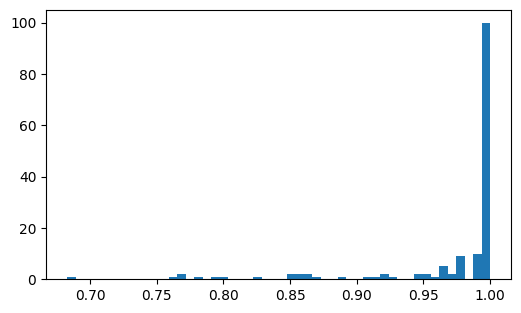

Number of inclusion rates < 1: 76


In [18]:
# Visualize average inclusion rate
fig, ax = plt.subplots(1,1,figsize=(6,3.5))

ax.hist(per_feature_inclusion_indics.mean(axis=0), bins=50)
plt.show()

print("Number of inclusion rates < 1:", (per_feature_inclusion_indics.mean(axis=0) < 1).sum())

In [19]:
# Sort features by average inclusion rate
sorted_features = bart_df.columns.values[2:][np.argsort(avg_inclusion_rate)]
sorted_avg_inclusion_rates = np.sort(avg_inclusion_rate)
print(sorted_features[:5])
print(sorted_avg_inclusion_rates[:5])

['polviews' 'polviews_num' 'income_num' 'income' 'racdif1_1']
[0.68283061 0.76132161 0.76849949 0.76849949 0.78091011]


In [20]:
# See how much of region is replicated by first five features
top5_features = sorted_features[:5]
top5_inclusion_indics = per_feature_inclusion_indics[:,np.isin(bart_df.columns.values[2:],
                                                               top5_features)]
top5_inclusion_rate = top5_inclusion_indics.all(axis=1).mean()
print(top5_inclusion_rate)

0.4143174159612065


polviews: inclusion rate = 0.6828306073806197, trt effect = 0.3691166409451972
polviews_num: inclusion rate = 0.7613216076271883, trt effect = 0.3612817637394986
income_num: inclusion rate = 0.7684994931645708, trt effect = 0.3612158502277145
income: inclusion rate = 0.7684994931645708, trt effect = 0.3612158502277145
racdif1_1: inclusion rate = 0.7809101120517246, trt effect = 0.362430115354551
race: inclusion rate = 0.7913755787512671, trt effect = 0.3583034179144053
year: inclusion rate = 0.7984712747595957, trt effect = 0.3473004527181407
earnrs: inclusion rate = 0.8264157146379552, trt effect = 0.35369563580186747
occ80: inclusion rate = 0.8519218651543793, trt effect = 0.34464957618405667
prestg80: inclusion rate = 0.8532095011095586, trt effect = 0.3455991203887266


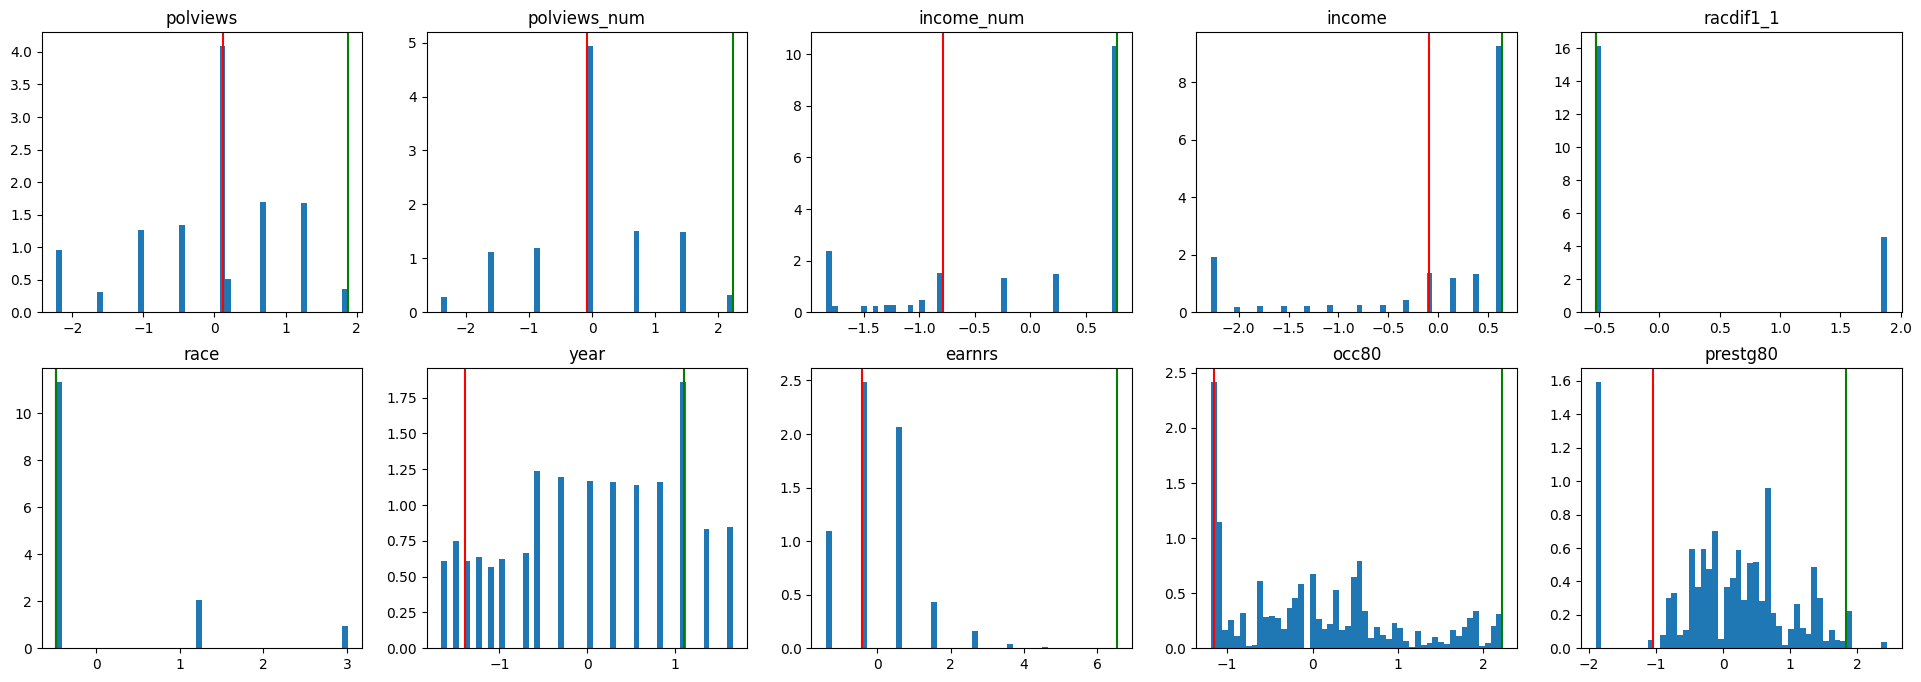

In [21]:
# Visualize top 10 features
fig, ax = plt.subplots(2,5,figsize=(24,8))

PANEL_COUNTER = 0
AX0, AX1 = PANEL_COUNTER // 5, PANEL_COUNTER % 5

for i in range(10):
    feat = sorted_features[i]
    # Calculate per feature subgroup ATE
    feat_region_inds = (region_bart_df.loc[:,feat].min() <= bart_df.loc[:,feat])
    feat_region_inds = feat_region_inds & (bart_df.loc[:,feat] <= region_bart_df.loc[:,feat].max())
    feat_region_df = bart_df.loc[feat_region_inds]
    feat_trt_effect_df = feat_region_df.groupby("treatment").outcome.mean()
    feat_trt_effect = feat_trt_effect_df[1] - feat_trt_effect_df[0]
    # Plot
    ax[AX0, AX1].hist(bart_df.loc[:,feat].values, bins=50, density=True)
    ax[AX0, AX1].axvline(region_bart_df.loc[:,feat].min(), color="red")
    ax[AX0, AX1].axvline(region_bart_df.loc[:,feat].max(), color="green")
    ax[AX0, AX1].set_title(feat)
    print("{}: inclusion rate = {}, trt effect = {}".format(feat, sorted_avg_inclusion_rates[i], feat_trt_effect))
    # Increment panel
    PANEL_COUNTER += 1
    AX0, AX1 = PANEL_COUNTER // 5, PANEL_COUNTER % 5
    
plt.show()

In [22]:
# Get indicators for points that were revealed randomly
meta = chiseling.protocol.protocol_metadata
rand_inds = meta[meta.is_random].orig_ind.values
rand_indics = np.isin(np.arange(len(TX)), rand_inds)
nonrand_indics = ~rand_indics

In [23]:
# Calculate the running estimate of intersection subgroup ATE compared to per-feature subgroup ATE
feat_region_inds = True
subgroup_ATEs = []
feat_subgroup_ATEs = []
subgroup_sizes = []
feat_subgroup_sizes = []
for feat in sorted_features:
    # Get the region indicators
    per_feat_region_inds = nonrand_indics
    per_feat_region_inds = per_feat_region_inds & (region_bart_df.loc[:,feat].min() <= bart_df.loc[:,feat])
    per_feat_region_inds = per_feat_region_inds & (bart_df.loc[:,feat] <= region_bart_df.loc[:,feat].max())
    feat_region_inds = feat_region_inds & per_feat_region_inds
    # Calculate ATEs
    per_feat_region_df = bart_df.loc[per_feat_region_inds]
    per_feat_trt_effect_df = per_feat_region_df.groupby("treatment").outcome.mean()
    per_feat_trt_effect = per_feat_trt_effect_df[1] - per_feat_trt_effect_df[0]
    feat_subgroup_ATEs.append(per_feat_trt_effect)
    subgroup_region_df = bart_df.loc[feat_region_inds]
    subgroup_trt_effect_df = subgroup_region_df.groupby("treatment").outcome.mean()
    subgroup_trt_effect = subgroup_trt_effect_df[1] - subgroup_trt_effect_df[0]
    subgroup_ATEs.append(subgroup_trt_effect)
    # Calculate sizes
    subgroup_sizes.append(feat_region_inds.mean())
    feat_subgroup_sizes.append(per_feat_region_inds.mean())
subgroup_ATEs = np.array(subgroup_ATEs)
feat_subgroup_ATEs = np.array(feat_subgroup_ATEs)
subgroup_sizes = np.array(subgroup_sizes)
feat_subgroup_sizes = np.array(feat_subgroup_sizes)

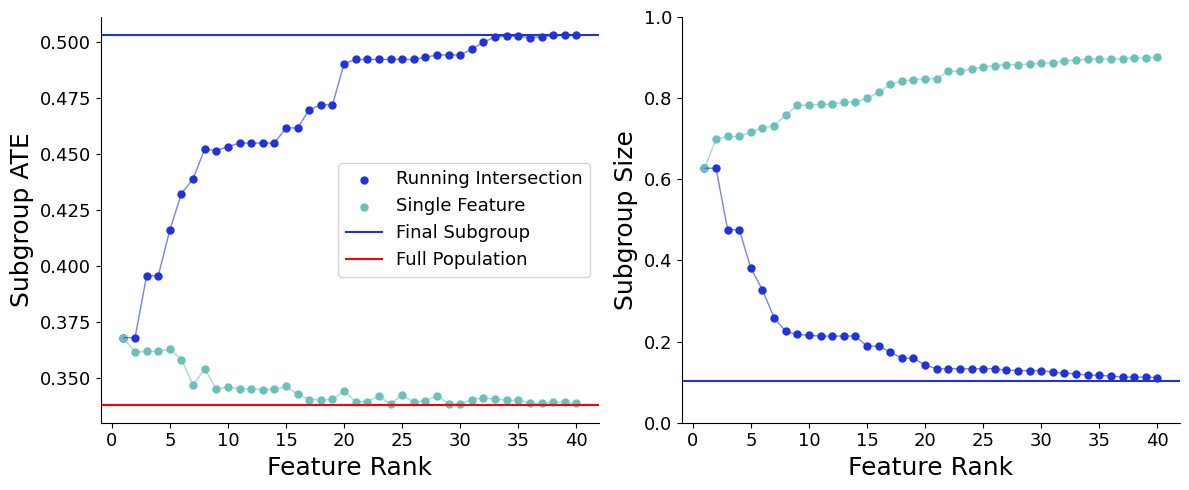

In [24]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

LABEL_FONTSIZE = 18
MARKERSIZE = 25
LINEWIDTH = 1
LINEALPHA = 0.6
TICK_FONTSIZE = 13
LEGEND_FONTSIZE = 13
FULL_COLOR = "#2032DA"
PER_COLOR = "#69C1B9"
FINAL_COLOR = "#2032DA"
ATE_COLOR = "red"

N_FEATURES = 40
FULL_TRT_EFFECT = bart_df.groupby("treatment").outcome.mean()[1] - bart_df.groupby("treatment").outcome.mean()[0]

ax[0].plot(np.arange(1,1+N_FEATURES), subgroup_ATEs[:N_FEATURES], color=FULL_COLOR, linewidth=LINEWIDTH, alpha=LINEALPHA)
ax[0].scatter(np.arange(1,1+N_FEATURES), subgroup_ATEs[:N_FEATURES], s=MARKERSIZE, label="Running Intersection",
              color=FULL_COLOR)
ax[0].plot(np.arange(1,1+N_FEATURES), feat_subgroup_ATEs[:N_FEATURES], color=PER_COLOR, linewidth=LINEWIDTH, alpha=LINEALPHA)
ax[0].scatter(np.arange(1,1+N_FEATURES), feat_subgroup_ATEs[:N_FEATURES], s=MARKERSIZE, label="Single Feature",
              color=PER_COLOR)
ax[0].axhline(subgroup_ATEs[-1], color=FINAL_COLOR, label="Final Subgroup")
ax[0].axhline(FULL_TRT_EFFECT, color=ATE_COLOR, label="Full Population")
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)

ax[1].plot(np.arange(1,1+N_FEATURES), subgroup_sizes[:N_FEATURES], color=FULL_COLOR, linewidth=LINEWIDTH, alpha=LINEALPHA)
ax[1].scatter(np.arange(1,1+N_FEATURES), subgroup_sizes[:N_FEATURES], s=MARKERSIZE, label="Running Intersection",
              color=FULL_COLOR)
ax[1].plot(np.arange(1,1+N_FEATURES), feat_subgroup_sizes[:N_FEATURES], color=PER_COLOR, linewidth=LINEWIDTH, alpha=LINEALPHA)
ax[1].scatter(np.arange(1,1+N_FEATURES), feat_subgroup_sizes[:N_FEATURES], s=MARKERSIZE, label="Single Feature",
              color=PER_COLOR)
ax[1].axhline(subgroup_sizes[-1], color=FINAL_COLOR, label="Final Subgroup")
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)

# Global formatting
ax[0].set_ylabel("Subgroup ATE", fontsize=LABEL_FONTSIZE)
ax[0].set_xlabel("Feature Rank", fontsize=LABEL_FONTSIZE)
ax[1].set_ylabel("Subgroup Size", fontsize=LABEL_FONTSIZE)
ax[1].set_xlabel("Feature Rank", fontsize=LABEL_FONTSIZE)
ax[1].set_ylim(0,1)
ax[0].legend(fontsize=LEGEND_FONTSIZE)
plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "bart_interpret_facet_min.pdf", bbox_inches="tight", dpi=300)

plt.show()